In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'
from statsmodels.nonparametric.smoothers_lowess import lowess

In [26]:
df = pd.read_csv('GLB.Ts+dSST.csv', header=1)

df['Mean'] = df.loc[:,'Jan':'Dec'].mean(1)
df['Median'] = df.loc[:, 'Jan':'Dec'].median(1)
df['Min'] = df.loc[:, 'Jan':'Dec'].min(1)
df['Max'] = df.loc[:, 'Jan':'Dec'].max(1)
df.index = df.Year

df_norm = df.loc[:, 'Jan':'Dec']
dfmax = df_norm.max().max()
_dfmax = (-df_norm).max().max()
df_norm[df_norm>0] /= dfmax
df_norm[df_norm<0] /= _dfmax

months = df.loc[:,'Jan':'Dec'].columns

In [27]:
scatter_RGB = np.array([[242, 108, 9]]) / 255
grid_RGB = 225 / 255 * np.ones(3)
text_RGB = 100 / 255 * np.ones(3)
line_RGB = 90 / 255 * np.ones(3)
text2_RGB = 50 / 255 * np.ones(3)

median_RGB = '#1E377D'

def annotate_with_arrow(ax, text, xy, xy_text, fontsize=10, shrinkA=5, shrinkB=10):
    ax.annotate(text, xy, xy_text,
                horizontalalignment='left', verticalalignment='bottom',
                fontsize=fontsize,
                arrowprops=dict(arrowstyle="->",
                                shrinkA=shrinkA,
                                shrinkB=shrinkB,
                                connectionstyle="arc3,rad=0.3",
                                color=text_RGB), zorder=10)
    
def annotate(ax, text, xy, xytext=None, fontsize=10, color=None, align='left'):
    if xytext is None:
        xytext = xy
    ax.annotate(text, xy, xytext, fontsize=fontsize, color=color,
                horizontalalignment=align, verticalalignment='bottom', zorder=10)

def annotate_title(ax, text, xy, fontsize=10):
    ax.annotate(text, xy,
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize,
            color='k', fontweight='bold', fontstretch='0',
            backgroundcolor='white', zorder=10)


cdict = {'red':  ((0.0, 50/255, 50/255),
                   (0.2, 50/255, 50/255),
                   (0.5, 1.0, 1.0),
                   (0.55, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 143/255, 143/255),
                   (0.2, 160/255, 160/255),
                   (0.5, 1.0, 1.0),
                   (0.65, 200/255, 200/255),
                   (1.0, 140/255, 140/255)),

         'blue':  ((0.0, 255/255, 255/255),
                   (0.45, 255/255, 255/255),
                   (0.5, 1.0, 1.0),
                   (0.65, 100/255, 100/255),
                   (1.0, 60/255, 60/255))
        }

plt.register_cmap(name='Custom', data=cdict)

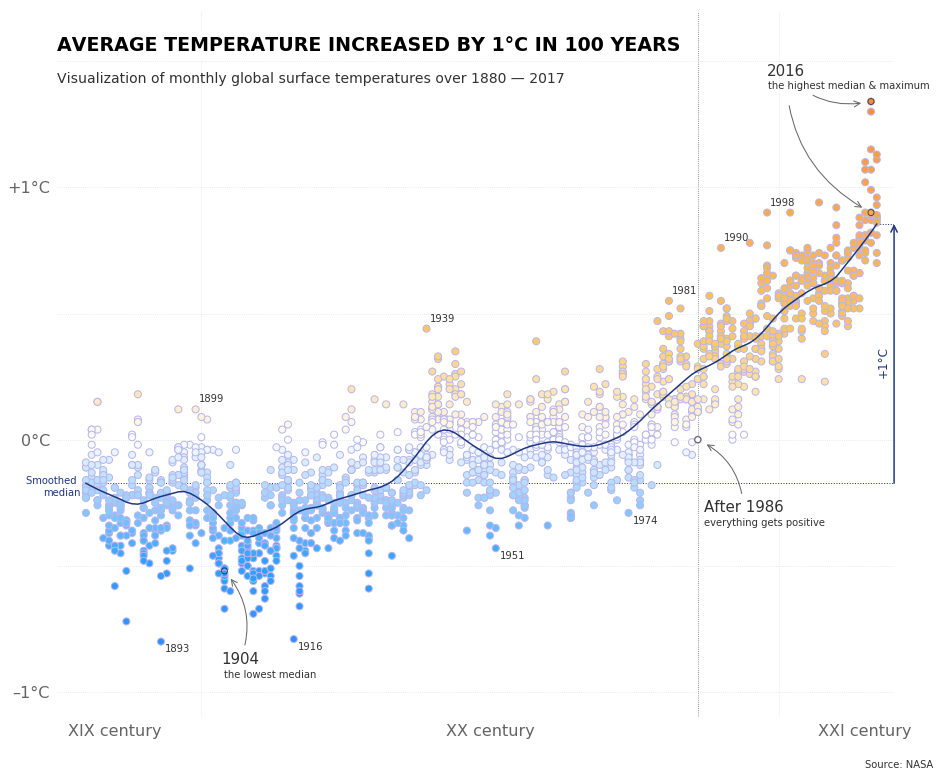

In [33]:
mpl.rcParams['figure.figsize'] = (15,13)
plt.rcParams['ytick.color'] = text_RGB
plt.rcParams['xtick.color'] = text_RGB
plt.rcParams['grid.color'] = grid_RGB
plt.rcParams['text.color'] = text2_RGB
plt.rcParams['font.size'] = 16

fig = plt.figure()
ax = fig.add_subplot(111)

years = [1885, 1950, 2015]
years_labels = ['XIX century', 'XX century', 'XXI century']
years_ticks = [1900, 2000]
degrees = np.round(np.linspace(-1, 1, 3), 1)
degrees_ticks = np.round(np.linspace(-1, 1.5, 6), 1)

ax.set_frame_on(False)
xlims = (1875, 2020)
ylims = (-1.1, 1.7)
ax.set_xlim(*xlims)
# ax.hlines(0, *xlims, colors=line_RGB, linewidth=0.8)
ax.set_ylim(*ylims)

ax.grid(which='minor', alpha=1, linestyle=':')
ax.grid(which='major', alpha=0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{}{:.0f}°C'\
                                     .format('+' if x>0 else ''if x==0 else'–',
                                             abs(x),
                                             'C' if x==1.2 else ''))
plt.gca().yaxis.set_major_formatter(formatter)
ax.set_xticks(years)
plt.xticks(years, years_labels)
ax.set_xticks(years_ticks, minor=True)
ax.set_yticks(degrees)
ax.set_yticks(degrees_ticks, minor=True)

xs, ys, cs = [], [], []
for i, month in enumerate(months):
    xs.extend(df.Year)
    ys.extend(df[month])
    cs.extend(df_norm[month])
ax.scatter(xs, ys, s=50, c=cs,
           edgecolors='#b7b7eb', cmap='Custom',
           alpha=1, zorder=2)
    

# Highlight local maxima
max_years_highlighted = [1899, 1939, 1981, 1990, 1998]
for year in max_years_highlighted:
    annotate(ax, year, (year, df.Max[year]), (year+0.5, df.Max[year]+0.02))
    
# Highlight local minima
min_years_highlighted = [1893, 1916, 1951, 1974]
for year in min_years_highlighted:
    annotate(ax, year, (year, df.Min[year]), (year+0.7, df.Min[year]-0.05))

# Average & min-max trend
t = np.arange(1,len(df.Year)+1)
frac = 0.12
trend_median = lowess(np.array(df['Median']), t, frac=frac, missing='drop', return_sorted=False)
ax.plot(df.Year, trend_median, color=median_RGB, linestyle='-', linewidth=1.5)
trend_max = lowess(np.array(df['Max']), t, frac=frac, missing='drop', return_sorted=False)
trend_min = lowess(np.array(df['Min']), t, frac=frac, missing='drop', return_sorted=False)
# ax.fill_between(df.Year, trend_min, trend_max, color='orange',
#                 linestyle='-', linewidth=2, alpha=0.1, zorder=12)

# Annotations
annotate(ax, 'Smoothed \nmedian', (1879, -0.23), color=median_RGB, fontsize=10, align='right')

point = (1986, 0.0)
annotate_with_arrow(ax, 'After 1986', point, (1987, -0.3), 15)
annotate(ax, 'everything gets positive', (1987, -0.35))
ax.scatter(*point, color='None', edgecolors='#000000', alpha=0.6, zorder=12)
ax.vlines(1986, -1.1, 1.7, colors=text_RGB, linewidth=0.8, linestyle=':', zorder=0)

point = (2016, df.Median[2016])
annotate_with_arrow(ax, '2016', point, (1998, 1.43), 15, 25)
ax.scatter(*point, color='None', edgecolors='#000000', alpha=0.6, zorder=12)
point = (2016, df.Max[2016])
annotate_with_arrow(ax, '       ', point, (1998, 1.43), 15, 25)
ax.scatter(*point, color='None', edgecolors='#000000', alpha=0.6, zorder=12)
annotate(ax, 'the highest median & maximum', (1998.1, 1.38))

point = (1904, df.Median[1904])
annotate_with_arrow(ax, '1904', point, (1903.5, -0.9), 15)
ax.scatter(*point, color='None', edgecolors='#000000', alpha=0.6, zorder=12)
annotate(ax, 'the lowest median', (1904, -0.95))

# Visualize change
ax.hlines(trend_median[0], 1880, 2020, colors=median_RGB, linewidth=1, linestyle=':', zorder=0)
ax.hlines(trend_median[-1], 2017, 2020, colors=median_RGB, linewidth=1, linestyle=':', zorder=0)
ax.annotate('', (2020, trend_median[-1]), (2020, trend_median[0]),
            arrowprops=dict(arrowstyle="->",
                            shrinkA=0,
                            shrinkB=0,
                            connectionstyle="arc3,rad=0",
                            color=median_RGB,
                            linewidth=1.5), zorder=100)
ax.text(2017, 0.33, '+1°C', rotation=90, color=median_RGB, fontsize=12)

# Title
annotate_title(ax, 'Average temperature increased by {:.0f}°C in 100 years'\
               .format(df.Median.iloc[-1] - df.Median.iloc[0]).upper(),
               (1875, 1.6), fontsize=19)
# Subtitle
annotate(ax, 'Visualization of monthly global surface temperatures over 1880 — 2017', (1875, 1.4), fontsize=14)

ax.text(2015, -1.3, 'Source: NASA', fontsize=10)

plt.savefig('vis.png')
plt.show()

У заголовку — основний месседж роботи — середня температура значно підвищилась за останні ~100 років. Графік побудовано таким чином, щоб зконцентрувати увагу на теденцію підвищення температури впродовж років (до scatter plot місячних температур додано тренд медіани). Для наочності кольори відповідають значенням температур. Акцентуються роки з граничними температурами, а також "рекордсмени" з найнижчим та найвищим значеннями медіани температури. Окрім того період після 1986 року відокремлений від минулого, оскільки там усі середні місячні температури мають вже тільки додатні значення, що, на мою думку, є досить показово.